In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
from pathlib import Path
Path("/gdrive/MyDrive/Colab Notebooks/").mkdir(parents=True, exist_ok=True)
%ls /gdrive/MyDrive/Colab\ Notebooks/

Mounted at /gdrive
/gdrive
 all_processed_train_X.csv                   obesity_train.csv
 all_processed_train_y.csv                   obesity_train_X.csv
 Classification.ipynb                        obesity_train_y.csv
 correlation_heatmap.png                     outlier/
 distribution/                               outlier_flagging.png
 evaluation/                                 Preprocessing_all.ipynb
 low_variance_features.png                   processed_train_X.csv
 models/                                     processed_train_y.csv
 ObesityDataSet_raw_and_data_sinthetic.csv   RamdonForest.ipynb
 obesity_test.csv                            summary/
 obesity_test_X.csv                          target_balance.png
 obesity_test_y.csv                          Term_Project_Preprocessing.ipynb
'obesity_test_y.csv 的副本'


In [44]:
import pandas as pd
# Load the datasets
X = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/all_processed_train_X.csv')
y = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/all_processed_train_y.csv')
Path("/gdrive/MyDrive/Colab Notebooks/evaluation/").mkdir(parents=True, exist_ok=True)
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1688 non-null   int64  
 1   Age                             1688 non-null   int64  
 2   Height                          1688 non-null   float64
 3   Weight                          1688 non-null   float64
 4   family_history_with_overweight  1688 non-null   int64  
 5   FAVC                            1688 non-null   int64  
 6   FCVC                            1688 non-null   int64  
 7   NCP                             1688 non-null   int64  
 8   CAEC                            1688 non-null   int64  
 9   SMOKE                           1688 non-null   int64  
 10  CH2O                            1688 non-null   int64  
 11  SCC                             1688 non-null   int64  
 12  FAF                             16

In [45]:
from sklearn.model_selection import train_test_split
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1350, 16), (338, 16), (1350, 1), (338, 1))

In [46]:
print("y_train percentage distribution:")
print(y_train.value_counts(normalize=True) * 100)

y_train percentage distribution:
NObeyesdad         
Obesity_Type_I         16.296296
Obesity_Type_III       16.074074
Overweight_Level_II    14.148148
Obesity_Type_II        13.777778
Overweight_Level_I     13.629630
Normal_Weight          13.555556
Insufficient_Weight    12.518519
Name: proportion, dtype: float64


In [47]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Shapes of the datasets
print("Original Training Set Shape:", X_train.shape, y_train.shape)
print("After SMOTE Training Set Shape:", X_train_smote.shape, y_train_smote.shape)
print("Test Set Shape (unchanged):", X_test.shape, y_test.shape)
print("y_train percentage distribution:")
print(y_train_smote.value_counts(normalize=True) * 100)

Original Training Set Shape: (1350, 16) (1350, 1)
After SMOTE Training Set Shape: (1540, 16) (1540, 1)
Test Set Shape (unchanged): (338, 16) (338, 1)
y_train percentage distribution:
NObeyesdad         
Insufficient_Weight    14.285714
Normal_Weight          14.285714
Obesity_Type_I         14.285714
Obesity_Type_II        14.285714
Obesity_Type_III       14.285714
Overweight_Level_I     14.285714
Overweight_Level_II    14.285714
Name: proportion, dtype: float64


In [48]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical labels into integers
label_encoder = LabelEncoder()
y_train_smote = label_encoder.fit_transform(y_train_smote)  # Fit and transform on testing data


# Retrieve the mapping of original labels to integers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original -> Encoded):", label_mapping)

# Encode categorical labels into integers
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)  # Fit and transform on testing data


# Retrieve the mapping of original labels to integers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original -> Encoded):", label_mapping)

Label Mapping (Original -> Encoded): {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}
Label Mapping (Original -> Encoded): {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [49]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
import pandas as pd
import numpy as np
import tempfile
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
temp_dir = tempfile.mkdtemp()
def prediction(model, X):
    # Predict on the given dataset
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)  # Full probability matrix for multi-class
    return y_pred, y_proba

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Scores in training dataset
    y_pred, y_proba = prediction(model, X_train)
    train_f1_macro = f1_score(y_train, y_pred, average='macro')
    train_auroc = roc_auc_score(y_train, y_proba, multi_class='ovr')  # One-vs-rest approach
    train_accuracy = accuracy_score(y_train, y_pred)  # Top-1 Accuracy

    print(f"Macro F1-Score on Train Set: {train_f1_macro:.4f}")
    print(f"AUROC Score on Train Set: {train_auroc:.4f}")
    print(f"Top-1 Accuracy on Train Set: {train_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

    # Scores in testing dataset
    y_pred, y_proba = prediction(model, X_test)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    test_auroc = roc_auc_score(y_test, y_proba, multi_class='ovr')  # One-vs-rest approach
    test_accuracy = accuracy_score(y_test, y_pred)  # Top-1 Accuracy

    print(f"Macro F1-Score on Test Set: {test_f1_macro:.4f}")
    print(f"AUROC Score on Test Set: {test_auroc:.4f}")
    print(f"Top-1 Accuracy on Test Set: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'f1_score_train': train_f1_macro,
        'roc_auc_train': train_auroc,
        'accuracy_train': train_accuracy,
        'f1_score_test': test_f1_macro,
        'roc_auc_test': test_auroc,
        'accuracy_test': test_accuracy
    }

# Ensure y_train and y_test are in the correct shape
y_train_smote = y_train_smote.ravel()  # Convert to NumPy array and flatten to 1D
y_test = y_test.ravel()

# List to store model scores
f1_score_train = []
roc_auc_score_train = []
accuracy_score_train = []
f1_score_test = []
roc_auc_score_test = []
accuracy_score_test = []

model_params = {
    "RandomForestClassifier": {
        "class_weight": "balanced",
        "max_depth": 10,
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "n_estimators": 200,
        "max_features": "sqrt",
    },
    "GradientBoostingClassifier": {
        "learning_rate": 0.05,
        "n_estimators": 200,
        "max_depth": 3,
        "subsample": 0.8,
        "min_samples_split": 10,
        "min_samples_leaf": 5,
        "max_features": "sqrt",
        "random_state": 42,
    },
    "XGBClassifier": {
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "n_estimators": 300,
        "gamma": 1,
        "min_child_weight": 3,
    },
    "LGBMClassifier": {
        "boosting_type": "gbdt",
        "max_depth": -1,
        "learning_rate": 0.05,
        "n_estimators": 300,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "num_leaves": 31,
        "random_state": 42,
    },
    "CatBoostClassifier": {
        "train_dir": temp_dir,
        "iterations": 300,
        "depth": 6,
        "learning_rate": 0.05,
        "loss_function": "MultiClass",
        "random_seed": 42,
        "verbose": 0,
    },
}

model_classes = {
    "RandomForestClassifier": RandomForestClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier,
    "XGBClassifier": XGBClassifier,
    "LGBMClassifier": LGBMClassifier,
    "CatBoostClassifier": CatBoostClassifier,
}

# Initialize models
models = [
    model_classes[model_name](**params)
    for model_name, params in model_params.items()
]

model_names = []
model_parameters = []
for model in models:
    model_names.append(model.__class__.__name__)
    model_parameters.append(model_params[model.__class__.__name__])
    model.fit(X_train_smote, y_train_smote)
    scores = evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test)
    f1_score_train.append(scores['f1_score_train'])
    roc_auc_score_train.append(scores['roc_auc_train'])
    accuracy_score_train.append(scores['accuracy_train'])
    f1_score_test.append(scores['f1_score_test'])
    roc_auc_score_test.append(scores['roc_auc_test'])
    accuracy_score_test.append(scores['accuracy_test'])

# Compile results
results = pd.DataFrame()
results['Model_Name'] = model_names
train_test_f1_score_difference = np.subtract(f1_score_train, f1_score_test)  # To Check Overfitting/Underfitting
results['Top-1 Accuracy on Test Set'] = accuracy_score_test
results['F1_Score on Test Set'] = f1_score_test
results['ROC_AUC_Score on Test Set'] = roc_auc_score_test
results['Top-1 Accuracy on Train Set'] = accuracy_score_train
results['F1_Score on Train Set'] = f1_score_train
results['ROC_AUC_Score on Train Set'] = roc_auc_score_train
results['Difference of F1_Score on train and test'] = train_test_f1_score_difference
results['Parameters'] = model_parameters
results = results.sort_values(by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'], ascending=[False, True])
results.to_csv('/gdrive/MyDrive/Colab Notebooks/evaluation/models_results_with_all_features.csv', index=False)
results


Macro F1-Score on Train Set: 0.9922
AUROC Score on Train Set: 0.9999
Top-1 Accuracy on Train Set: 0.9922
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       220
           1       0.97      1.00      0.98       220
           2       1.00      0.99      1.00       220
           3       1.00      1.00      1.00       220
           4       1.00      1.00      1.00       220
           5       0.99      0.98      0.98       220
           6       0.99      0.98      0.99       220

    accuracy                           0.99      1540
   macro avg       0.99      0.99      0.99      1540
weighted avg       0.99      0.99      0.99      1540

Macro F1-Score on Test Set: 0.9249
AUROC Score on Test Set: 0.9947
Top-1 Accuracy on Test Set: 0.9260
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.77      0.88      0.

,Model_Name,Top-1 Accuracy on Test Set,F1_Score on Test Set,ROC_AUC_Score on Test Set,Top-1 Accuracy on Train Set,F1_Score on Train Set,ROC_AUC_Score on Train Set,Difference of F1_Score on train and test,Parameters
3,LGBMClassifier,0.964497,0.963951,0.998786,1.000000,1.000000,1.000000,0.036049,"{'boosting_type': 'gbdt', 'max_depth': -1, 'le..."
4,CatBoostClassifier,0.949704,0.948906,0.998094,0.994805,0.994807,0.999972,0.045900,"{'train_dir': '/tmp/tmpvd4gdw59', 'iterations'..."
2,XGBClassifier,0.946746,0.947202,0.996694,0.988312,0.988308,0.999816,0.041107,"{'max_depth': 5, 'learning_rate': 0.05, 'subsa..."
1,GradientBoostingClassifier,0.931953,0.929969,0.994335,0.997403,0.997406,0.999986,0.067436,"{'learning_rate': 0.05, 'n_estimators': 200, '..."
0,RandomForestClassifier,0.926036,0.924910,0.994746,0.992208,0.992223,0.999909,0.067313,"{'class_weight': 'balanced', 'max_depth': 10, ..."


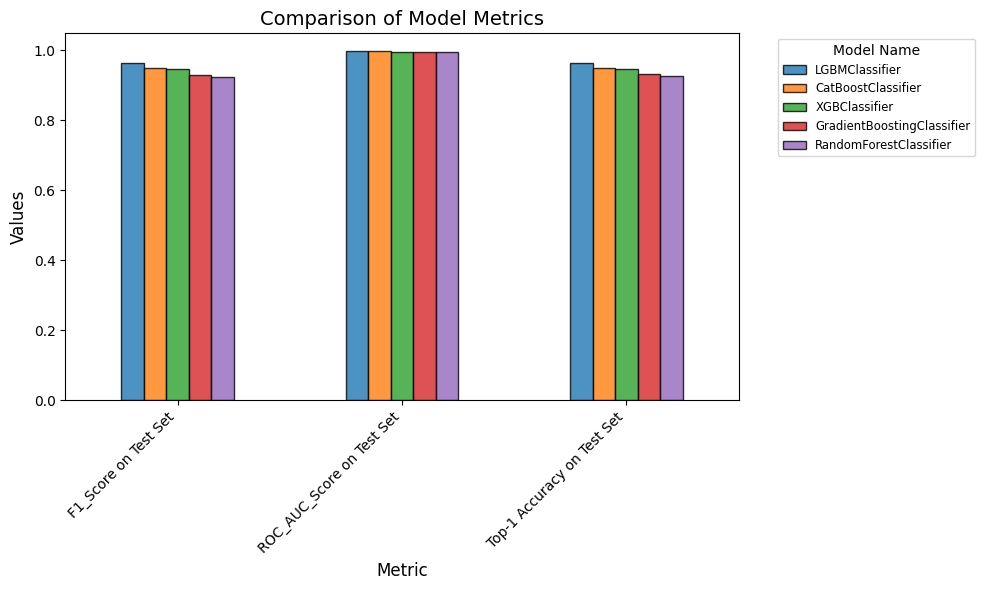

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
results = results.sort_values(by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'], ascending=[False, True])
# Metrics to plot
metrics_to_plot = [
    'Top-1 Accuracy on Test Set',
    'F1_Score on Test Set',
    'ROC_AUC_Score on Test Set'
]

# Reshape the DataFrame
reshaped_results = results.melt(
    id_vars=['Model_Name'],
    value_vars=metrics_to_plot,
    var_name='Metric',
    value_name='Value'
).pivot(index='Metric', columns='Model_Name', values='Value')

# Reorder rows by 'Top-1 Accuracy on Test Set'
model_order = results['Model_Name']
reshaped_results = reshaped_results[model_order]

# Plotting
reshaped_results.plot(kind='bar', figsize=(10, 6), alpha=0.8, edgecolor='black')

# Customizing the plot
plt.title('Comparison of Model Metrics', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

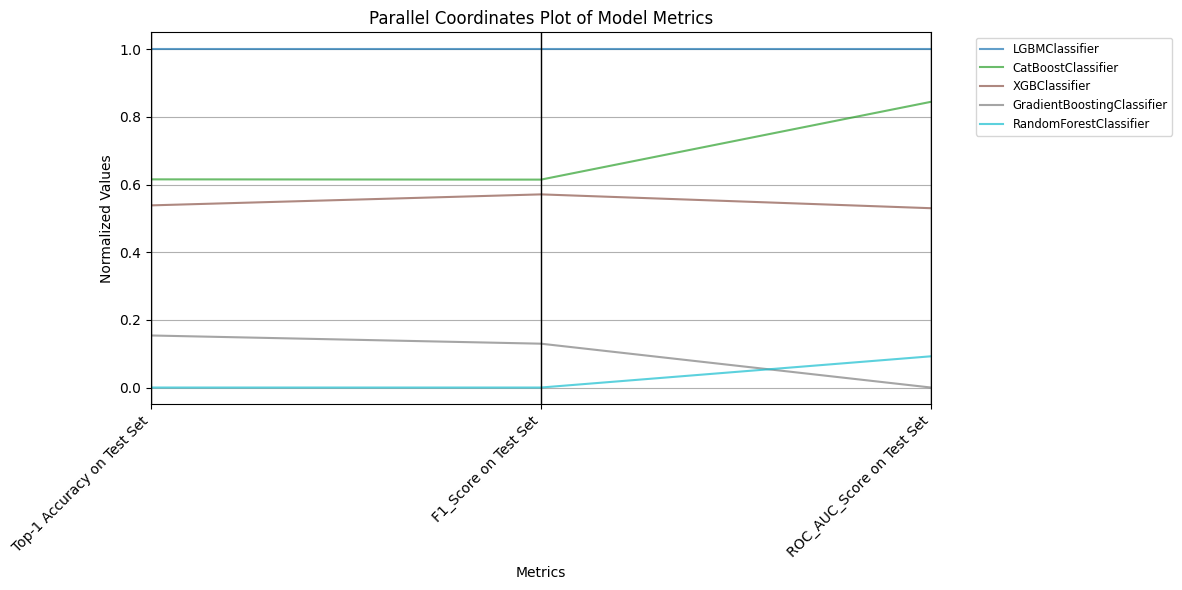

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Normalize the metrics for better visualization
metrics_to_plot = [
    'Top-1 Accuracy on Test Set',
    'F1_Score on Test Set',
    'ROC_AUC_Score on Test Set'
]

# Normalizing the values to range [0, 1] for fair comparison
normalized_results = results.copy()
for metric in metrics_to_plot:
    normalized_results[metric] = (results[metric] - results[metric].min()) / (results[metric].max() - results[metric].min())

# Add a new column for better labeling (Model Name + Index)
normalized_results['Model_Label'] = normalized_results['Model_Name']

# Plot Parallel Coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(
    normalized_results[['Model_Label'] + metrics_to_plot],
    class_column='Model_Label',
    colormap=plt.get_cmap('tab10'),
    alpha=0.7
)

# Customizing the plot
plt.title('Parallel Coordinates Plot of Model Metrics')
plt.xlabel('Metrics')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()



Feature selection

In [ ]:
drop_columns=['Height','Weight']
Z=X.copy()
Z=Z.drop(drop_columns, axis=1)
Z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Gender                          1688 non-null   int64
 1   Age                             1688 non-null   int64
 2   family_history_with_overweight  1688 non-null   int64
 3   FAVC                            1688 non-null   int64
 4   FCVC                            1688 non-null   int64
 5   NCP                             1688 non-null   int64
 6   CAEC                            1688 non-null   int64
 7   SMOKE                           1688 non-null   int64
 8   CH2O                            1688 non-null   int64
 9   SCC                             1688 non-null   int64
 10  FAF                             1688 non-null   int64
 11  TUE                             1688 non-null   int64
 12  CALC                            1688 non-null   int64
 13  MTR

In [ ]:
# Split train and test dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(Z, y, test_size=0.20, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((1350, 14), (338, 14), (1350, 1), (338, 1))

In [ ]:
# Encode categorical labels into integers
label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)  # Fit and transform on testing data


# Retrieve the mapping of original labels to integers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original -> Encoded):", label_mapping)

# Encode categorical labels into integers
label_encoder = LabelEncoder()
y1_test = label_encoder.fit_transform(y1_test)  # Fit and transform on testing data


# Retrieve the mapping of original labels to integers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original -> Encoded):", label_mapping)

Label Mapping (Original -> Encoded): {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}
Label Mapping (Original -> Encoded): {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Check the balance of the target variable 'has_died' in train_y
target_balance = y1_train.value_counts(normalize=True)
# Display the target balance
print("Target Balance:", target_balance)

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X1_train_smote, y1_train_smote = smote.fit_resample(X1_train, y1_train)

# Shapes of the datasets
print("Original Training Set Shape:", X1_train.shape, y1_train.shape)
print("After SMOTE Training Set Shape:", X1_train_smote.shape, y1_train_smote.shape)
print("Test Set Shape (unchanged):", X1_test.shape, y1_test.shape)

Original Training Set Shape: (1350, 14) (1350,)
After SMOTE Training Set Shape: (1540, 14) (1540,)
Test Set Shape (unchanged): (338, 14) (338,)


In [ ]:
# Ensure y_train and y_test are in the correct shape
y1_train_smote = y1_train_smote.ravel()  # Convert to NumPy array and flatten to 1D
y1_test = y1_test.ravel()

# List to store model scores
f1_score_train = []
roc_auc_score_train = []
accuracy_score_train = []
f1_score_test = []
roc_auc_score_test = []
accuracy_score_test = []

model_names = []
model_parameters = []
for model in models:
    model_names.append(model.__class__.__name__)
    model_parameters.append(model_params[model.__class__.__name__])
    model.fit(X1_train_smote, y1_train_smote)
    scores = evaluate_model(model, X1_train_smote, y1_train_smote, X1_test, y1_test)
    f1_score_train.append(scores['f1_score_train'])
    roc_auc_score_train.append(scores['roc_auc_train'])
    accuracy_score_train.append(scores['accuracy_train'])
    f1_score_test.append(scores['f1_score_test'])
    roc_auc_score_test.append(scores['roc_auc_test'])
    accuracy_score_test.append(scores['accuracy_test'])

# Compile results
results1 = pd.DataFrame()
results1['Model_Name'] = model_names
train_test_f1_score_difference = np.subtract(f1_score_train, f1_score_test)  # To Check Overfitting/Underfitting
results1['Top-1 Accuracy on Test Set'] = accuracy_score_test
results1['F1_Score on Test Set'] = f1_score_test
results1['ROC_AUC_Score on Test Set'] = roc_auc_score_test
results1['Top-1 Accuracy on Train Set'] = accuracy_score_train
results1['F1_Score on Train Set'] = f1_score_train
results1['ROC_AUC_Score on Train Set'] = roc_auc_score_train
results1['Difference of F1_Score on train and test'] = train_test_f1_score_difference
results1['Parameters'] = model_parameters
results1 = results1.sort_values(by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'], ascending=[False, True])
results1.to_csv('/gdrive/MyDrive/Colab Notebooks/evaluation/models_results_with_feature_selection.csv', index=False)
results1

Macro F1-Score on Train Set: 0.9000
AUROC Score on Train Set: 0.9922
Top-1 Accuracy on Train Set: 0.9006
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       220
           1       0.86      0.85      0.85       220
           2       0.87      0.86      0.87       220
           3       0.87      0.97      0.92       220
           4       0.98      1.00      0.99       220
           5       0.87      0.85      0.86       220
           6       0.90      0.81      0.86       220

    accuracy                           0.90      1540
   macro avg       0.90      0.90      0.90      1540
weighted avg       0.90      0.90      0.90      1540

Macro F1-Score on Test Set: 0.7498
AUROC Score on Test Set: 0.9546
Top-1 Accuracy on Test Set: 0.7574
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        47
           1       0.50      0.48      0.

,Model_Name,Top-1 Accuracy on Test Set,F1_Score on Test Set,ROC_AUC_Score on Test Set,Top-1 Accuracy on Train Set,F1_Score on Train Set,ROC_AUC_Score on Train Set,Difference of F1_Score on train and test,Parameters
3,LGBMClassifier,0.789941,0.787195,0.957348,0.988961,0.988960,0.999909,0.201765,"{'boosting_type': 'gbdt', 'max_depth': -1, 'le..."
4,CatBoostClassifier,0.775148,0.767360,0.952991,0.908442,0.908023,0.992246,0.140663,"{'train_dir': '/tmp/tmpvzak1oaq', 'iterations'..."
0,RandomForestClassifier,0.757396,0.749795,0.954587,0.900649,0.899982,0.992204,0.150186,"{'class_weight': 'balanced', 'max_depth': 10, ..."
2,XGBClassifier,0.751479,0.744141,0.942010,0.837662,0.835292,0.981076,0.091152,"{'max_depth': 5, 'learning_rate': 0.05, 'subsa..."
1,GradientBoostingClassifier,0.748521,0.744003,0.934714,0.840260,0.838268,0.980706,0.094265,"{'learning_rate': 0.05, 'n_estimators': 200, '..."


經過feature selection 模型表現都下降

尋找最佳模型

In [52]:
# Find the row corresponding to the best model
feature_selection=False
if feature_selection:
  best_parameters = results1.sort_values(
    by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'],
    ascending=[False, True]
  )['Parameters'].iloc[0]
  best_model_name = results1.sort_values(
      by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'],
      ascending=[False, True]
  )['Model_Name'].iloc[0]
else:
  best_parameters = results.sort_values(
      by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'],
      ascending=[False, True]
  )['Parameters'].iloc[0]
  best_model_name = results.sort_values(
      by=['Top-1 Accuracy on Test Set', 'Difference of F1_Score on train and test'],
      ascending=[False, True]
  )['Model_Name'].iloc[0]

print("Best Model:", best_model_name)
print("Best Parameters:", best_parameters)

# Map model names to their corresponding classes
model_classes = {
    "RandomForestClassifier": RandomForestClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier,
    "XGBClassifier": XGBClassifier,
    "LGBMClassifier": LGBMClassifier,
    "CatBoostClassifier": CatBoostClassifier
}

# Instantiate the best model with its parameters
BestModelClass = model_classes[best_model_name]
best_model = BestModelClass(**best_parameters)
# Train the best model
if feature_selection:
  best_model.fit(X1_train_smote, y1_train_smote)
else:
  best_model.fit(X_train_smote, y_train_smote)

print(f"{best_model_name} has been trained with the best parameters.")
# Evaluate the best model on the test set
from sklearn.metrics import classification_report, accuracy_score
if feature_selection:
  y_pred = best_model.predict(X1_test)
else:
  y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Best Model on Test Set: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

import joblib

# Save the trained best model
joblib.dump(best_model, '/gdrive/MyDrive/Colab Notebooks/evaluation/best_model.pkl')
print("Best model saved successfully.")

Best Model: LGBMClassifier
Best Parameters: {'boosting_type': 'gbdt', 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8, 'num_leaves': 31, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 16
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [57]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
# Encode categorical labels into integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Fit and transform on testing data

# Define the SMOTE instance
smote = SMOTE(random_state=42)

# Define the stratified k-fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with SMOTE and the best model
pipeline = Pipeline([
    ('smote', smote),
    ('model', best_model)
])

scoring = {
    'F1_macro': make_scorer(f1_score, average='macro'),
    'Top1_Accuracy': make_scorer(accuracy_score),
    'AUROC': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
}


# Perform cross-validation
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train.ravel(),
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=False
)

# Evaluate and display results
print("Cross-validation results:")
for metric, scores in cv_results.items():
    if 'test' in metric:  # Only show test metrics
        print(f"{metric}: Mean={scores.mean():.4f}, Std={scores.std():.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-validation results:
test_F1_macro: Mean=0.9596, Std=0.0053
test_Top1_Accuracy: Mean=0.9607, Std=0.0050
test_AUROC: Mean=0.9978, Std=0.0016


In [59]:
# Fit the pipeline on the full training data
pipeline.fit(X_train, y_train)

# Access the model from the pipeline
final_model = pipeline.named_steps['model']

# Check if the model has feature_importances_
if hasattr(final_model, 'feature_importances_'):
    # Create a DataFrame to store feature importance
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(20)
    #feature_importances = final_model.feature_importances_
    #print("Feature Importances:")
    #for idx, importance in enumerate(feature_importances):
    #    print(f"Feature {idx}: {importance:.4f}")
    print(feature_importances)
    # Save to CSV
    filename = f"/gdrive/MyDrive/Colab Notebooks/evaluation/{best_model_name}_feature_importance.csv"
    feature_importances.to_csv(filename, index=False)
    print(f"Feature importance for {best_model_name} saved to {filename}")
else:
    print("The model does not have a feature_importances_ attribute.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 16
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
# Calculate feature importance if the model supports it
if hasattr(best_model, "feature_importances_"):
  if feature_selection:
    feature_importances = pd.DataFrame({
        'Feature': Z.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(20)
  else:
    # Create a DataFrame to store feature importance
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(20)
  print(feature_importances)
  # Save to CSV
  filename = f"/gdrive/MyDrive/Colab Notebooks/evaluation/{best_model_name}_top_20_features.csv"
  feature_importances.to_csv(filename, index=False)
  print(f"Top 20 features for {best_model_name} saved to {filename}")

                           Feature  Importance
3                           Weight       13025
2                           Height       11187
1                              Age        5422
12                             FAF        1956
7                              NCP        1632
13                             TUE        1461
6                             FCVC        1355
10                            CH2O        1217
14                            CALC        1082
8                             CAEC        1063
0                           Gender         965
5                             FAVC         878
15                          MTRANS         875
4   family_history_with_overweight         651
11                             SCC         356
9                            SMOKE          26
Top 20 features for LGBMClassifier saved to /gdrive/MyDrive/Colab Notebooks/evaluation/LGBMClassifier_top_20_features.csv


載入外部測試資料集

In [ ]:
# Load the feature dataset (X) and label dataset (y)
X_validation = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/obesity_test_X.csv')
y_validation = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/obesity_test_y.csv')

if feature_selection:
  X_validation = X_validation.drop(drop_columns, axis=1)

# Ensure labels are in the correct shape (1D array)
y_validation = y_validation.values.ravel()  # Flatten to 1D array if necessary

print(f"Validation Data Shape: {X_validation.shape}, {y_validation.shape}")
X_validation.columns


Validation Data Shape: (423, 16), (423,)


Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')

In [ ]:
categorical_cols = X_validation.select_dtypes(include=['object']).columns

print("Before encode DataFrame:")
print(X_validation.shape)
# Apply encoding based on non-ordinal or ordinal classification
for col in categorical_cols:
    label_encoder = LabelEncoder()
    X_validation[col] = label_encoder.fit_transform(X_validation[col])

# Final check to see the transformed DataFrame
print("Encoded DataFrame:")
print(X_validation.head())
# Display the shape of the dataset
print(X_validation.shape)

Before encode DataFrame:
(423, 16)
Encoded DataFrame:
   Gender  Age    Height      Weight  family_history_with_overweight  FAVC  \
0       0   20  1.755978   53.699561                               1     1   
1       0   26  1.624950  111.004920                               1     1   
2       1   18  1.850000   60.000000                               1     1   
3       0   21  1.520000   42.000000                               0     1   
4       1   22  1.750000   74.000000                               1     0   

   FCVC  NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  
0     2    3     1      0     1    0    2    2     2       3  
1     3    3     2      0     2    0    0    0     1       3  
2     3    4     2      0     2    1    2    0     1       0  
3     3    1     1      0     1    0    0    0     1       3  
4     2    3     2      0     2    0    1    2     1       1  
(423, 16)


In [ ]:
# Flatten y to a 1D array
y_validation = y_validation.ravel()  # or y_validation.flatten()

# Encode categorical labels into integers
label_encoder = LabelEncoder()
y_validation = label_encoder.fit_transform(y_validation)  # Fit and transform on testing data


# Retrieve the mapping of original labels to integers
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original -> Encoded):", label_mapping)

Label Mapping (Original -> Encoded): {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [ ]:
import joblib
# Load the saved model
best_model = joblib.load('/gdrive/MyDrive/Colab Notebooks/evaluation/best_model.pkl')
print("Best model loaded successfully.")


Best model loaded successfully.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score
# Predict on the validation dataset
y_pred = best_model.predict(X_validation)
y_proba = best_model.predict_proba(X_validation)  # Use for AUROC

# Evaluate the performance
accuracy = accuracy_score(y_validation, y_pred)
f1_macro = f1_score(y_validation, y_pred, average='macro')

# Compute AUROC
try:
    auroc = roc_auc_score(y_validation, y_proba, multi_class='ovr')  # One-vs-rest for multi-class
except ValueError:
    auroc = "Not Applicable (e.g., single class in y_validation)"

# Print Metrics
print(f"Accuracy on Validation Set: {accuracy:.4f}")
print(f"Macro F1-Score on Validation Set: {f1_macro:.4f}")
if isinstance(auroc, str):
    print(f"AUROC on Validation Set: {auroc}")
else:
    print(f"AUROC on Validation Set: {auroc:.4f}")

# Classification Report
print("Classification Report on Validation Set:")
print(classification_report(y_validation, y_pred))


Accuracy on Validation Set: 0.9693
Macro F1-Score on Validation Set: 0.9687
AUROC on Validation Set: 0.9989
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        56
           1       0.95      0.89      0.92        62
           2       0.99      0.99      0.99        78
           3       1.00      0.98      0.99        58
           4       1.00      1.00      1.00        63
           5       0.93      0.96      0.95        56
           6       1.00      0.98      0.99        50

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423

